In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

# Preparing the data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model Feature Analysis

In [8]:
class ModelFA:
    
    def __init__(self, n_components):
        self.n_components=n_components
        
    # spe: squared prediction errors
    def spe(self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)        
   
    def train(self, df_train):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.
        if self.n_components == 0:
            self.m = sklearn.decomposition.FactorAnalysis()
        else:
            self.m = sklearn.decomposition.FactorAnalysis(n_components=self.n_components)
            # Learn the inverse transform for non-precomputed kernels (i.e. learn
            # to find the pre-image of a point). This method is based on [2]
           
        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        
        # fit the model
        self.m.fit_transform(X_train) # only condition that can make sparse works
        
        # Manual Inverse Transform 
        dt_red = np.dot(X_train - self.m.mean_, self.m.components_.T)
        X_train_pred = np.dot(dt_red, self.m.components_) + self.m.mean_
        # X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test - self.mu_train) / self.std_train) 
        dt_red = np.dot(X_test - self.m.mean_, self.m.components_.T)
        X_test_pred = np.dot(dt_red, self.m.components_) + self.m.mean_
        # X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

# Training the Data

In [9]:
models = {'FA': ModelFA(0)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [10]:
detection_limits

{'FA': 5237.631826778541}

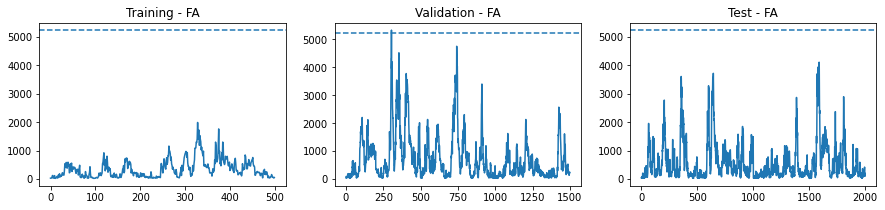

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - FA')
plt.axhline(detection_limits['FA'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - FA')
plt.axhline(detection_limits['FA'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - FA')
plt.axhline(detection_limits['FA'], ls = '--')

# Testing the Data

FA    27.83125
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
FA,42.5,2.5,0.0,0.0,18.25,96.5,27.125,81.875,0.0,2.875,0.0,84.375,78.75,0.5,0.0,1.375,23.875,89.125,0.0,7.0


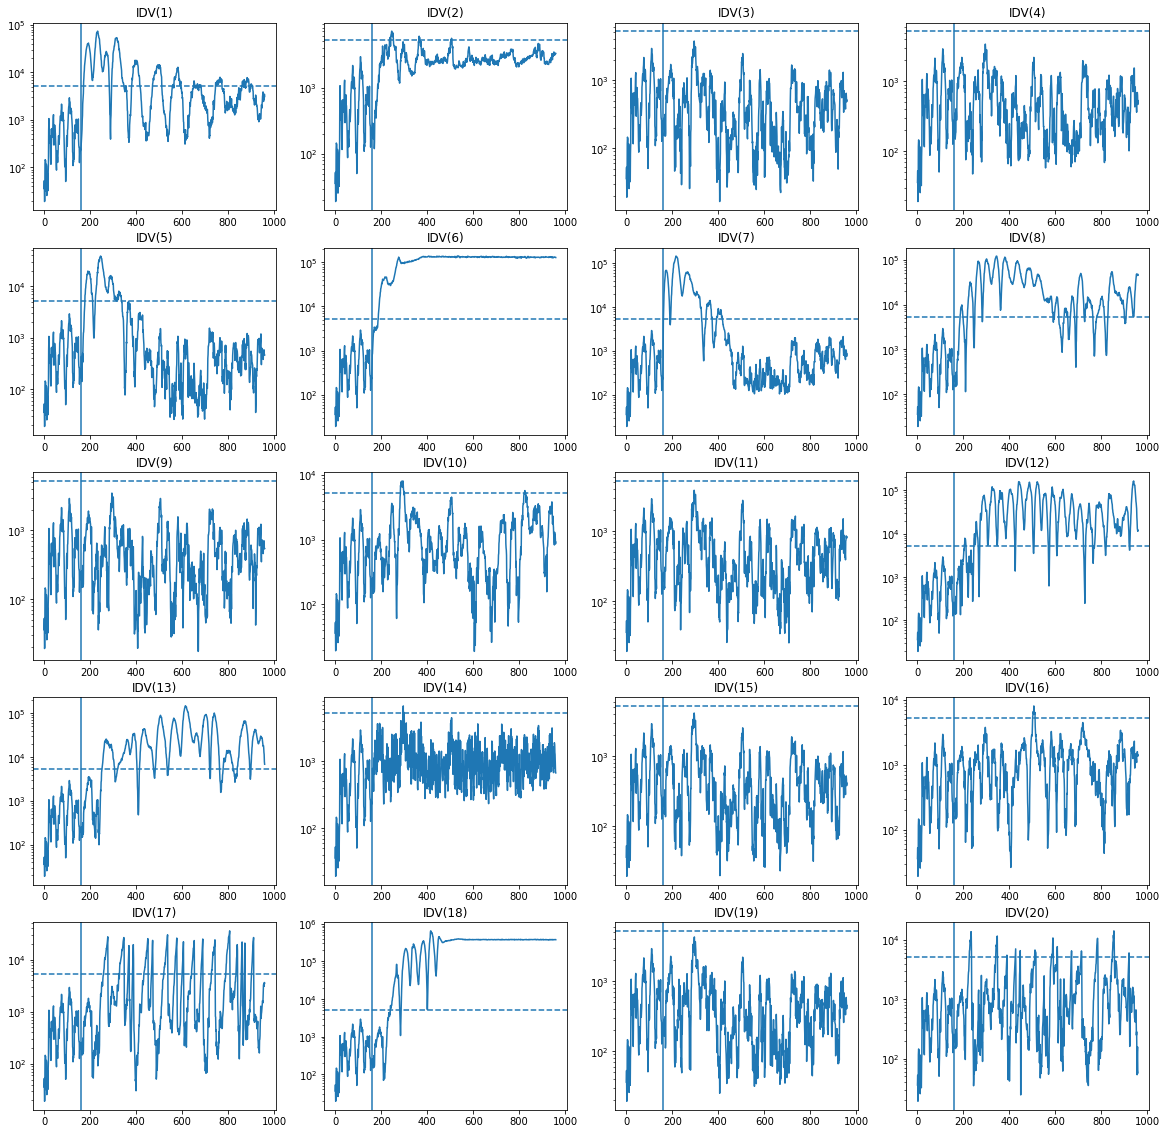

In [12]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

# Training the data with 30 n_components in the model

In [13]:
models = {'FA30': ModelFA(30)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [14]:
detection_limits

{'FA30': 5670.302047556275}

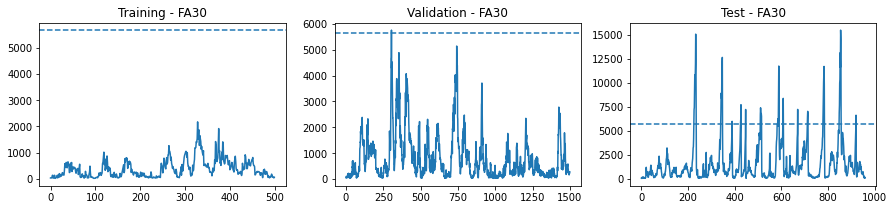

In [15]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - FA30')
plt.axhline(detection_limits['FA30'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - FA30')
plt.axhline(detection_limits['FA30'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - FA30')
plt.axhline(detection_limits['FA30'], ls = '--')

# Testing the new model

FA30    28.25625
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
FA30,46.375,4.75,0.0,0.0,18.625,96.625,27.125,82.375,0.0,2.875,0.0,84.625,78.875,0.5,0.0,1.375,24.625,89.25,0.0,7.125


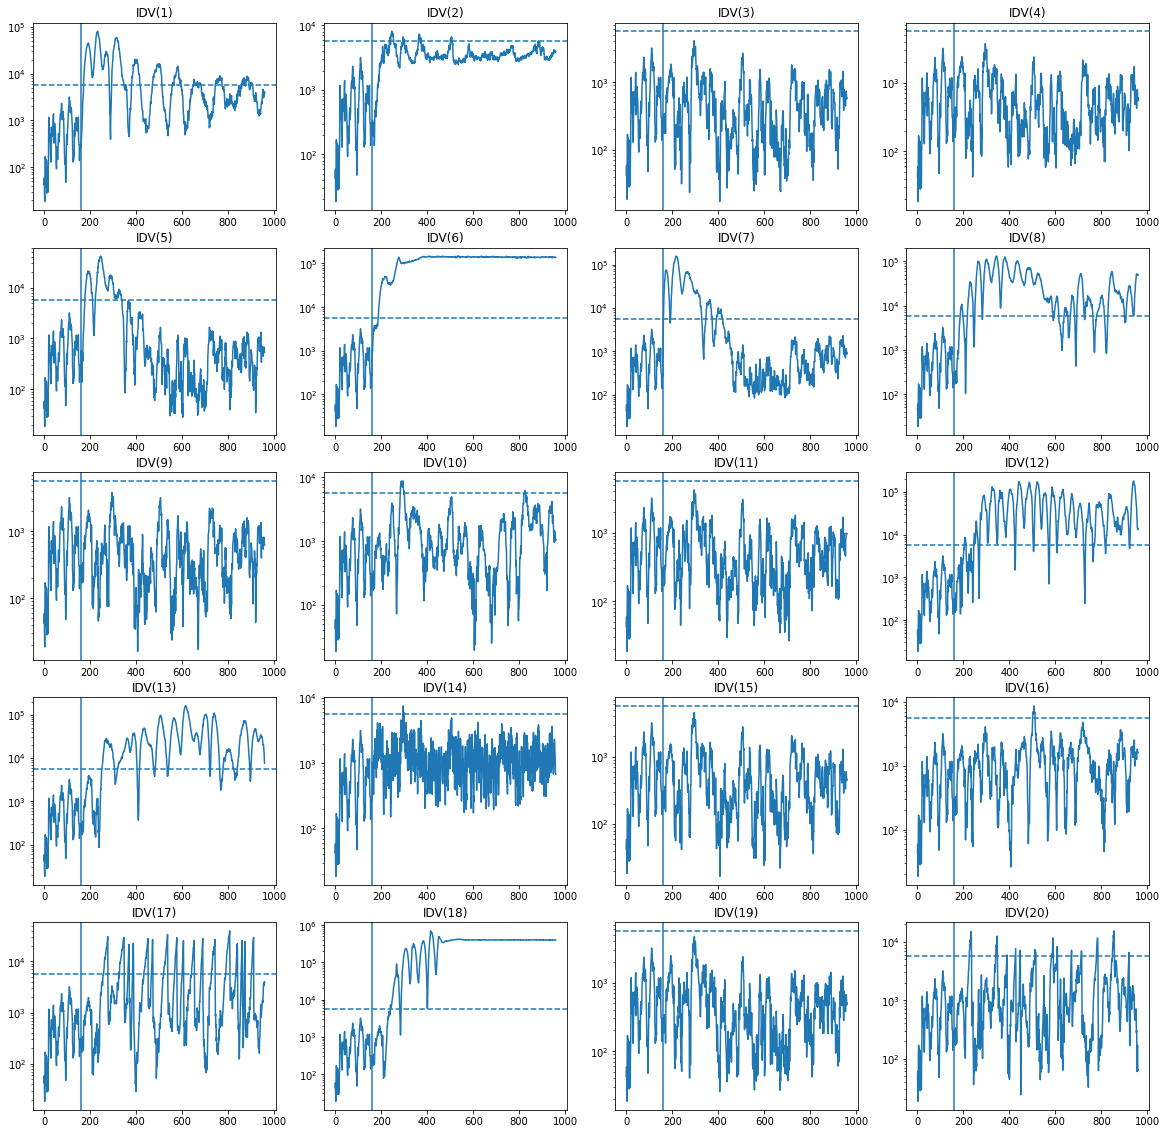

In [16]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

In [17]:
# fdr_df.to_csv('./experimental_result_csv/fa30.csv')

## Lag variables

In [18]:
def apply_lag(df, lag = 1):
       
    from statsmodels.tsa.tsatools import lagmat
    array_lagged = lagmat(df, maxlag=lag,
                          trim="forward", original='in')[lag:,:]  
    new_columns = []
    for l in range(lag):
        new_columns.append(df.columns+'_lag'+str(l+1))
    columns_lagged = df.columns.append(new_columns)
    index_lagged = df.index[lag:]
    df_lagged = pd.DataFrame(array_lagged, index=index_lagged,
                             columns=columns_lagged)
       
    return df_lagged  

## Noise filtering

In [19]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## Adding lag variables

fa_lag1    28.593750
fa_lag2    28.529412
fa_lag3    28.583960
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
fa_lag1,51.125000,5.125000,0.0,0.0,19.250000,96.625000,27.625000,84.125000,0.0,3.500000,0.0,85.250000,80.125000,0.0,0.0,1.500000,20.875000,89.250000,0.0,7.500000
fa_lag2,51.689612,5.381727,0.0,0.0,19.524406,96.620776,28.035044,84.355444,0.0,3.629537,0.0,85.481852,80.600751,0.0,0.0,1.376721,17.647059,89.111389,0.0,7.133917
fa_lag3,52.005013,5.388471,0.0,0.0,19.423559,96.741855,28.195489,85.213033,0.0,3.759398,0.0,85.839599,81.203008,0.0,0.0,1.503759,16.040100,89.348371,0.0,7.017544


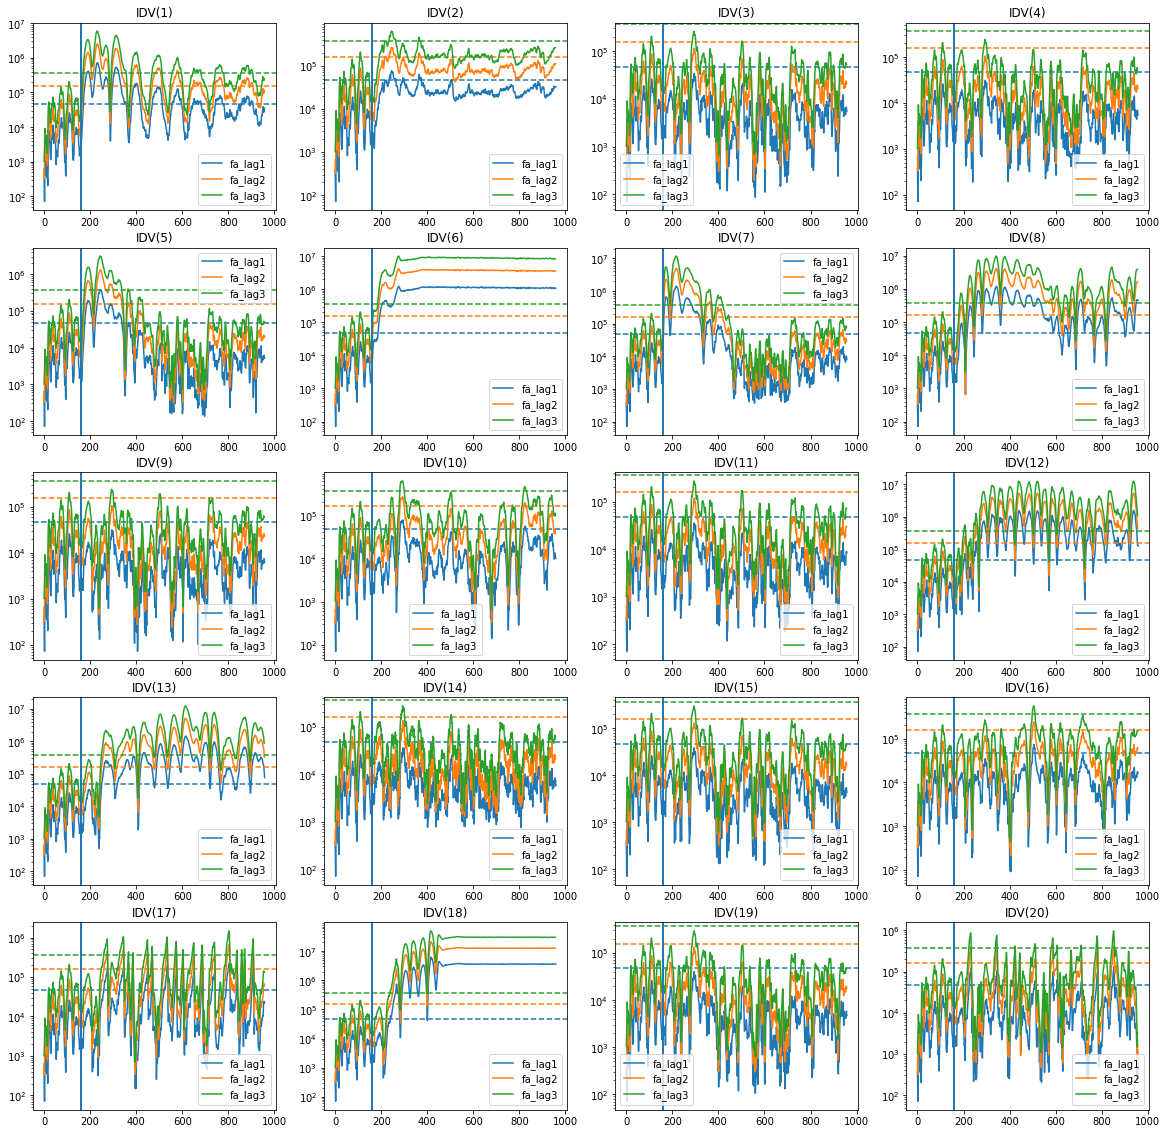

In [20]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'fa_lag1': ModelFA(30), 'fa_lag2': ModelFA(30), 'fa_lag3': ModelFA(30)}
lags = {'fa_lag1': 1, 'fa_lag2': 2, 'fa_lag3': 3}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(apply_lag(df_train,lags[name]))
    spe_validation = model.test(apply_lag(df_validation,lags[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = apply_lag(test_faulty[(test_faulty.faultNumber==i+1) & 
                                        (test_faulty.simulationRun==1)].iloc[:,3:], lags[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [21]:
# fdr_df.to_csv('./experimental_result_csv/falag.csv')

## Filter noise

WS_10     34.30000
WS_50     38.66875
WS_100    46.21250
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,74.125,71.500,0.0,0.000,21.00,96.375,29.875,84.375,0.0,4.250,0.0,87.375,78.875,0.0,0.0,1.625,43.375,90.375,0.0,2.875
WS_50,91.875,91.375,0.0,4.125,20.50,95.625,52.250,81.500,0.0,1.875,0.0,79.625,80.000,0.0,0.0,0.000,87.125,87.500,0.0,0.000
WS_100,97.500,92.625,0.0,91.000,19.75,96.625,98.625,88.875,0.0,0.000,0.0,65.375,84.000,0.0,0.0,0.000,88.250,87.000,0.0,14.625


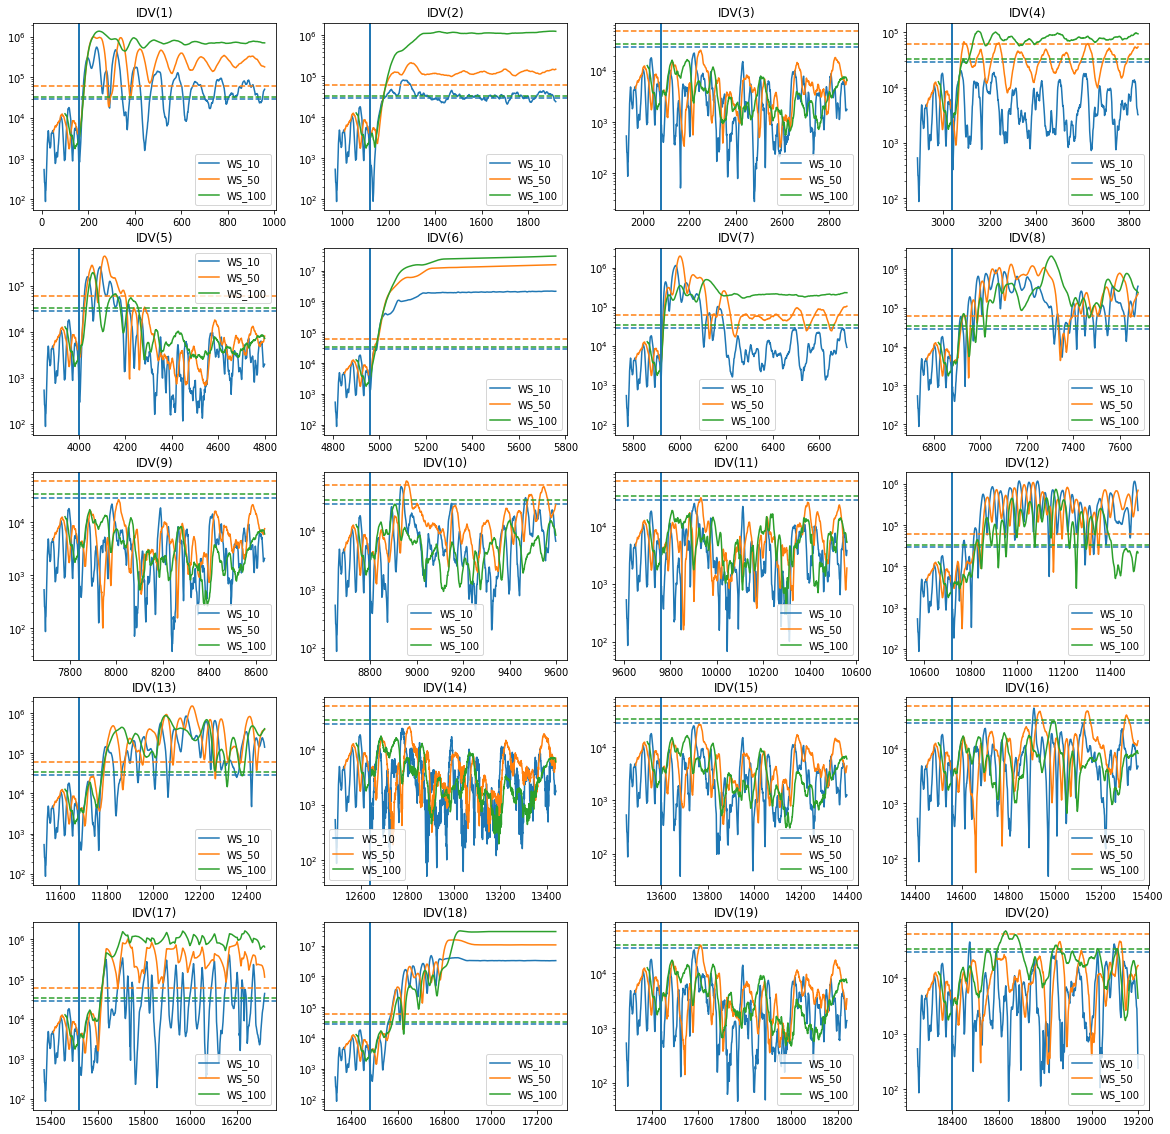

In [22]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelFA(30), 'WS_50': ModelFA(30), 'WS_100': ModelFA(30)}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [23]:
# fdr_df.to_csv('./experimental_result_csv/fanf.csv')

In [24]:
# spe_test